In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('twitter_new.csv',  encoding='latin')
df.head()
df.shape

(1599999, 6)

In [2]:
df.columns=["target", "id", "date", "flag","user", "text"]

In [3]:
df.head()

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
df["target"].value_counts()

4    800000
0    799999
Name: target, dtype: int64

In [5]:
print(df.shape)
df.info()


(1599999, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   id      1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
for i in df.columns:
    print(df[i].isnull().sum())

0
0
0
0
0
0


In [7]:
for i in df.columns:
    print(i, df[i].nunique())

target 2
id 1598314
date 774362
flag 1
user 659775
text 1581465


In [8]:
df.shape

(1599999, 6)

In [9]:
df.drop_duplicates(["user", "text"], inplace=True)

In [10]:
df.shape

(1594744, 6)

In [11]:
import numpy as np
import re

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    #temp = temp.split()
    #temp = [w for w in temp if not w in stopwords]
    #temp = " ".join(word for word in temp)
    return temp

In [12]:
df["processed_text"]=df["text"].apply(lambda x: clean_tweet(x))

C:\Users\HOME\AppData\Local\Temp\ipykernel_21460\3772667530.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


In [13]:
# Removing Stopwords Begin
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

stop_words = stopwords.words('english')

# Function to remove stop words 
def remove_stopwords(rev):
    # iNPUT : IT WILL TAKE ROW/REVIEW AS AN INPUT
    # take the paragraph, break into words, check if the word is a stop word, remove if stop word, combine the words into a para again
    review_tokenized = word_tokenize(rev)
    rev_new = " ".join([i for i in review_tokenized  if i not in stop_words])
    return rev_new

# Removing stopwords
df["processed_text"]= [remove_stopwords(r) for r in df['processed_text']]

In [16]:
# Begin Lemmatization 
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# function to convert nltk tag to wordnet tag
lemmatizer = WordNetLemmatizer()

# Finds the part of speech tag
# Convert the detailed POS tag into a shallow information
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
  # word tokenize -> pos tag (detailed) -> wordnet tag (shallow pos) -> lemmatizer -> root word
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


df['processed_text'] = df['processed_text'].progress_apply(lambda x: lemmatize_sentence(x))

100%|██████████████████████████████████████████████████████████████████████| 1594744/1594744 [20:44<00:00, 1281.57it/s]


In [17]:
df.to_csv("After_lemma.csv")

In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
df=pd.read_csv("After_lemma.csv")
df.head()

,Unnamed: 0,target,id,date,flag,user,text,processed_text
0,0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
1,1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dive many time ball manage save 50 rest go bound
2,2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behave im mad cant see
4,4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,whole crew


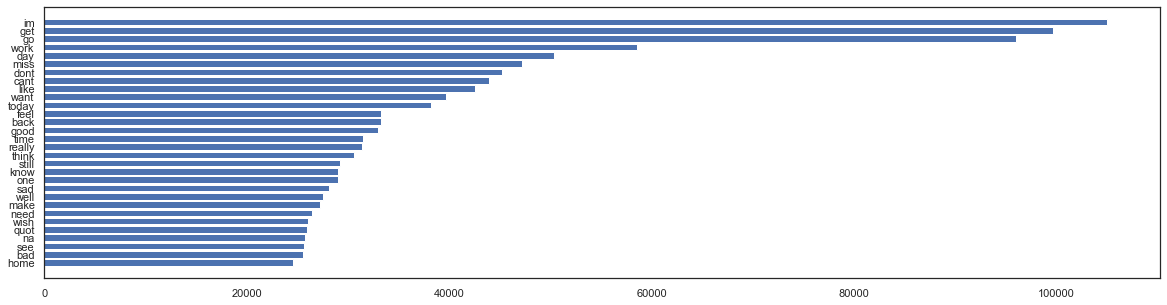

In [2]:
##
## Plotting most frequent words from positive reviews using bar chart
##
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white')
from nltk import FreqDist #function to find the frequent words in the data

# Subset positive review dataset
all_words_df = df.loc[df['target'] == 0,:]

#Extracts words into list and count frequency
all_words = ' '.join([str(text) for text in all_words_df['processed_text']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

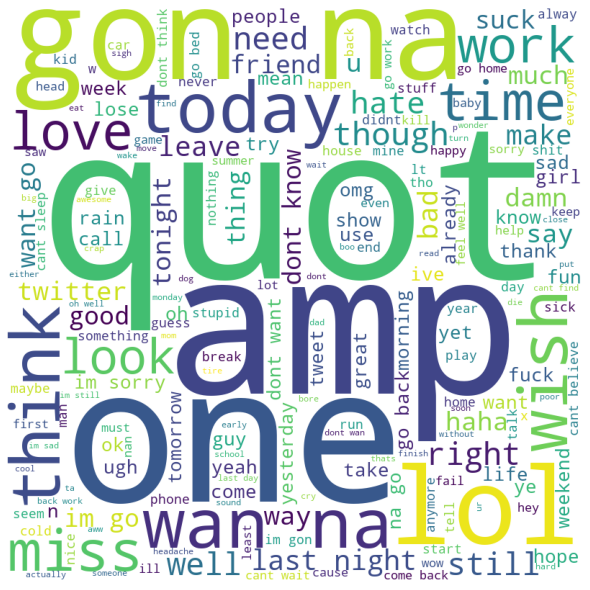

In [3]:
## Bilding a Word Cloud
## 
from wordcloud import WordCloud
word_cloud_df = df.loc[df['target'] == 0,:]
all_words = ' '.join([str(text) for text in word_cloud_df['processed_text']])
 

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [2]:
df.isnull().sum()

Unnamed: 0           0
target               0
id                   0
date                 0
flag                 0
user                 0
text                 0
processed_text    7594
dtype: int64

In [3]:
df.dropna(inplace=True)

In [4]:
# Importing module
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating matrix of top 2500 tokens
tfidf = TfidfVectorizer(max_features=1500)
# tmp_df = tfidf.fit_transform(df.review_processed)
# feature_names = tfidf.get_feature_names()
# pd.DataFrame(tmp_df.toarray(), columns = feature_names).head() 

X = tfidf.fit_transform(df.processed_text)
y = df.target.map({4 : 1, 0:0}).values
featureNames = tfidf.get_feature_names()


X, y



C:\Users\HOME\Documents\VS CODE PYTHON\STMLINE\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(<1587150x1500 sparse matrix of type '<class 'numpy.float64'>'
 	with 8579634 stored elements in Compressed Sparse Row format>,
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64))

In [5]:

# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)


In [6]:
df.shape

(1587150, 8)

In [7]:
X.shape

(1587150, 1500)

In [8]:
X_train.shape, X_test.shape

((1269720, 1500), (317430, 1500))

In [9]:
#BUILDIND ML MODEL 
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=15)
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
y_pred
#featureImportance = pd.DataFrame({i : j for i,j in zip(dt.feature_importances_,featureNames)},columns = ['Word','Importance'])



array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [10]:
#confusion_matrix, accuracy_score

from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("The model accuracy is", accuracy )

[[ 56382 102423]
 [ 14258 144367]]
The model accuracy is 0.6324197460857512


<AxesSubplot:>

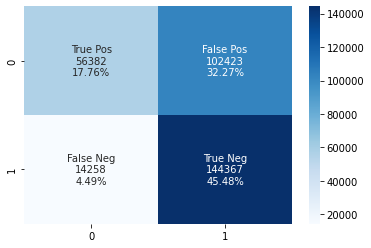

In [15]:
#Plotting confusion matrix
import numpy as np
import seaborn as sns
group_names = ["True Pos","False Pos","False Neg","True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

In [16]:
#Roc Score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

0.6745927724127719

In [17]:
#Gaussian Bias
from sklearn.naive_bayes import GaussianNB
X_train.toarray()
clf = GaussianNB()
clf.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [ ]:
##featureImportance.sort_values(by='Importance')
featureImportance = pd.DataFrame({i : j for i,j in zip(dt.feature_importances_,featureNames)}.items(),columns = ['Importance','word'])
featureImportance.sort_values(by='Importance',ascending=False)

In [ ]:
2**45